# [Project 3: Implementing a Simple Recurrent Neural Network (RNN)](https://github.com/jcp-tech/Seneca_Class_Notes/blob/master/Semester%202/AIG220%20-%20Deep%20Learning/Projects/Project%203/Project_3.ipynb)

## Introduction

In this project, you will design, implement, and evaluate a simple Recurrent Neural Network (RNN) from scratch. This will involve building the entire pipeline, from data preprocessing to model training and evaluation.

## Objectives

1. Set up TensorFlow or PyTorch environments. You are free to choose your preferred DL platform.
2. Use GPU for training.
3. Create a data loader and implement data preprocessing where needed.
4. Design a Recurrent Neural Network.
5. Train and evaluate your model. Make sure to clearly show loss and accuracy values. Include visualizations too.
6. Answer assessment questions.

## Dataset

You are free to choose any dataset for this project! Kaggle would be a good source to look for datasets. Below are some examples:
- Daily Minimum Temperatures in Melbourne: This dataset contains the daily minimum temperatures in Melbourne, Australia, from 1981 to 1990.
- Daily Bitcoin Prices: This dataset contains historical daily prices of Bitcoin, which can be used for time series forecasting projects.
- Text8 Dataset: This dataset consists of the first 100 million characters from Wikipedia. It's great for text generation or language modeling tasks.
- IMDB Movie Reviews: This dataset contains 50,000 movie reviews for sentiment analysis, split evenly into 25,000 training and 25,000 test sets.
- Jena Climate Dataset: This dataset records various weather attributes (temperature, pressure, humidity, etc.) every 10 minutes, making it ideal for time series analysis.
- Earthquake Aftershocks: This dataset contains seismic data, suitable for predicting aftershocks following major earthquakes.

In [99]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import os, sys, kagglehub, warnings
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import LSTM, Dense, Dropout # , GRU, SimpleRNN
print(tf.__version__)
warnings.filterwarnings('ignore')

2.18.0


In [100]:
gpu_available = tf.config.list_physical_devices('GPU')
if gpu_available:
    print("GPU is available and detected.")
    print(gpu_available)
else:
    print("No GPU detected. TensorFlow will use the CPU.")
    sys.exit("Exiting: No GPU found.")

GPU is available and detected.
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [101]:
path = kagglehub.dataset_download("rccrea/daily-minimum-temperature-in-melbourne")
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/daily-minimum-temperature-in-melbourne


In [102]:
csv_file = os.path.join(path, 'daily-min-temperatures.csv')
try:
    df = pd.read_csv(csv_file)
except FileNotFoundError:
    sys.exit(f"Error: The file {csv_file} was not found. Please check the file name and path.")
except Exception as e:
    sys.exit(f"An error occurred while loading the dataset: {e}")
df

,Date,Temp
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8
...,...,...
3645,1990-12-27,14.0
3646,1990-12-28,13.6
3647,1990-12-29,13.5
3648,1990-12-30,15.7


In [103]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3650 entries, 0 to 3649
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    3650 non-null   object 
 1   Temp    3650 non-null   float64
dtypes: float64(1), object(1)
memory usage: 57.2+ KB


In [104]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

In [105]:
## We Do Scalling to Standarise the Temp Data from Range of 0-1.
### Scale the temperature data to the range [0, 1] using Min-Max normalization.
### This helps improve model performance and training stability in neural networks.
scaler = MinMaxScaler(feature_range=(0, 1)) # Scale the temperature data
scaled_data = scaler.fit_transform(df['Temp'].values.reshape(-1, 1))
print("Scaled data =")
for idx in range(5):
    print(f"Original: {df['Temp'].values[idx]}, Scaled: {scaled_data[idx][0]}")

Scaled data =
Original: 20.7, Scaled: 0.7870722433460076
Original: 17.9, Scaled: 0.6806083650190113
Original: 18.8, Scaled: 0.714828897338403
Original: 14.6, Scaled: 0.5551330798479087
Original: 15.8, Scaled: 0.6007604562737643


In [106]:
## We Do Scaling to Normalize the Temperature Data to the Range [0, 1]
### Scale the temperature data to the range [0, 1] using Min-Max normalization.
### This ensures all input values are on the same scale, which improves model performance, speeds up convergence, and helps prevent issues caused by differing value ranges.
def create_sequences(data, sequence_length):
    """
    Create sequences of a given length from time series data.

    Parameters:
        data (np.ndarray): 1D or 2D array of shape (samples,) or (samples, features)
        sequence_length (int): Number of time steps to use for each input sequence

    Returns:
        tuple: X, y arrays
            - X: shape (num_samples, sequence_length, num_features)
            - y: shape (num_samples,)
    """
    if len(data.shape) == 1:
        data = data.reshape(-1, 1)

    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i + sequence_length])
        y.append(data[i + sequence_length])

    return np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)

sequence_length = 10
X, y = create_sequences(scaled_data, sequence_length)

print(f"\nShape of input sequences (X): {X.shape}")  # (samples, timesteps, features)
print(f"Shape of target values (y): {y.shape}")     # (samples,)

# Show sample input and target
print("\nFirst input sequence:")
print(X[0])
print("\nFirst target value:")
print(y[0])


Shape of input sequences (X): (3640, 10, 1)
Shape of target values (y): (3640, 1)

First input sequence:
[[0.78707224]
 [0.6806084 ]
 [0.7148289 ]
 [0.5551331 ]
 [0.60076046]
 [0.60076046]
 [0.60076046]
 [0.66159695]
 [0.82889736]
 [0.76045626]]

First target value:
[0.6159696]


In [107]:
# Train-test split (time series: NO shuffle)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

# Output final shapes
print(f"\nTraining data shape (X_train): {X_train.shape}")
print(f"Training data shape (y_train): {y_train.shape}")
print(f"Testing data shape (X_test): {X_test.shape}")
print(f"Testing data shape (y_test): {y_test.shape}")


Training data shape (X_train): (2912, 10, 1)
Training data shape (y_train): (2912, 1)
Testing data shape (X_test): (728, 10, 1)
Testing data shape (y_test): (728, 1)


In [108]:
# Define the RNN model
model = Sequential()
model.add(LSTM(units=100, activation='relu', return_sequences=True, input_shape=(sequence_length, 1)))
# model.add(GRU(units=100, activation='relu', input_shape=(sequence_length, 1))) # Alternative
# model.add(SimpleRNN(units=100, activation='relu', input_shape=(sequence_length, 1))) # Alternative
model.add(Dropout(0.2))
model.add(LSTM(units=50, activation='relu')) # Additional Layer
model.add(Dropout(0.2)) # Additional Layer
model.add(Dense(units=1))
model.compile(
    optimizer='adam',
    loss='mean_squared_error',
    metrics=['mean_absolute_error']
) # Compile the model
model.summary() # Display the model summary

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_7 (LSTM)                   │ (None, 10, 100)        │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 10, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 71,051 (277.54 KB)

 Trainable params: 71,051 (277.54 KB)

 Non-trainable params: 0 (0.00 B)

In [109]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True) # Define Early Stopping callback
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping]) # Train the model with Early Stopping

Epoch 1/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 9s 55ms/step - loss: 0.0856 - mean_absolute_error: 0.2329 - val_loss: 0.0124 - val_mean_absolute_error: 0.0862
Epoch 2/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0155 - mean_absolute_error: 0.0974 - val_loss: 0.0121 - val_mean_absolute_error: 0.0856
Epoch 3/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0146 - mean_absolute_error: 0.0941 - val_loss: 0.0116 - val_mean_absolute_error: 0.0835
Epoch 4/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0144 - mean_absolute_error: 0.0955 - val_loss: 0.0115 - val_mean_absolute_error: 0.0833
Epoch 5/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0139 - mean_absolute_error: 0.0935 - val_loss: 0.0116 - val_mean_absolute_error: 0.0831
Epoch 6/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0137 - mean_absolute_error: 0.0916 - val_loss: 0.0112 - val_mean_absolute_error: 0.0817
Epoch 7/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0130 - mean_absolute_error: 0.0896 - val_los

In [110]:
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0) # Evaluate the model on the test set
predicted_scaled_temperatures = model.predict(X_test) # Make predictions on the test set
print(f"\nTest Loss (MSE): {test_loss:.4f}")
print(f"Test MAE: {test_mae:.4f}")

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step

Test Loss (MSE): 0.0069
Test MAE: 0.0652


In [111]:
# Inverse transform the scaled predictions and actual values to the original scale
predicted_temperatures = scaler.inverse_transform(predicted_scaled_temperatures)
actual_temperatures = scaler.inverse_transform(y_test.reshape(-1, 1))

rmse = np.sqrt(mean_squared_error(actual_temperatures, predicted_temperatures))
print(f"Root Mean Squared Error (RMSE) on original scale: {rmse:.2f} °C")

mae = mean_absolute_error(actual_temperatures, predicted_temperatures)
print(f"Mean Absolute Error (MAE) on original scale: {mae:.2f} °C")

Root Mean Squared Error (RMSE) on original scale: 2.19 °C
Mean Absolute Error (MAE) on original scale: 1.71 °C


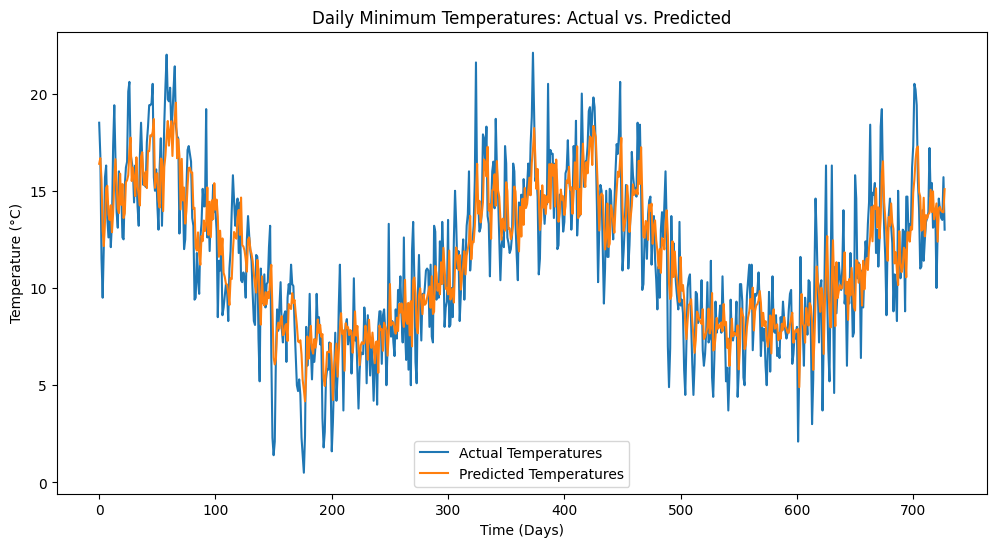

In [112]:
# Visualize the results
plt.figure(figsize=(12, 6))
plt.plot(actual_temperatures, label='Actual Temperatures')
plt.plot(predicted_temperatures, label='Predicted Temperatures')
plt.title('Daily Minimum Temperatures: Actual vs. Predicted')
plt.xlabel('Time (Days)')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.show()

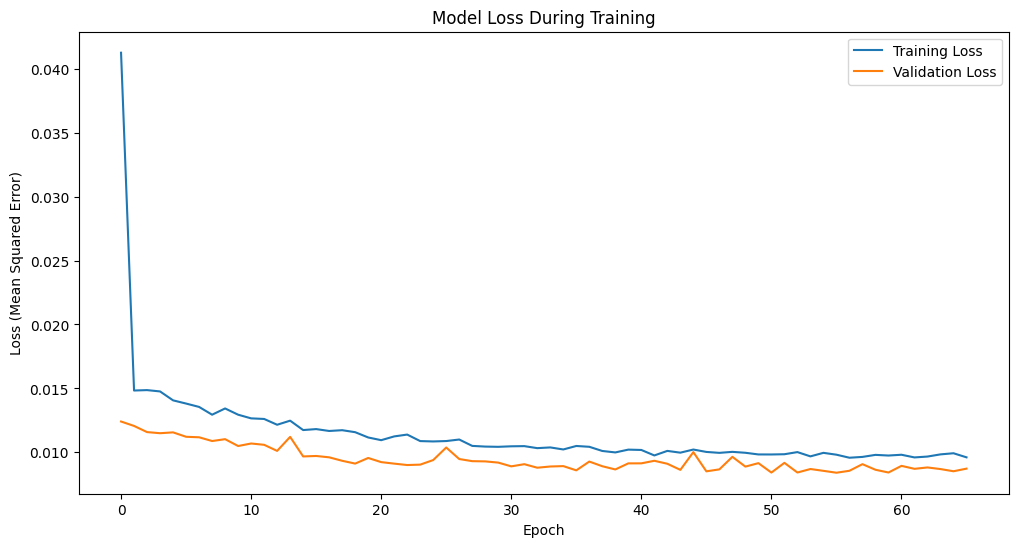

In [113]:
# Visualize the training history (loss)
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss (Mean Squared Error)')
plt.legend()
plt.show()

---
## Questions & Answers

### 1. What is a Recurrent Neural Network (RNN)? Describe its key components and how they differ from those in a feedforward neural network.

A **Recurrent Neural Network (RNN)** is a type of neural network designed to handle sequential data by maintaining a hidden state that is updated at each time step. The key difference from feedforward neural networks is the presence of **recurrent connections**—loops in the architecture that allow information to persist across sequence steps. This makes RNNs especially effective for time series, language modeling, and any data where context matters.

**Key Components:**

* **Input layer:** Receives the input sequence (e.g., time series, text).
* **Hidden state:** Stores information about previous inputs, updated at each time step.
* **Recurrent connections:** Feed the hidden state from one time step into the next.
* **Output layer:** Produces predictions (either at every step or at the end).

**Difference from Feedforward NN:** In a feedforward network, the output only depends on the current input. In RNNs, the output at each time step depends on the current input *and* the previous hidden state, giving the model a form of memory.

<br>

### 2. Explain the purpose of the recurrent connection in an RNN. How does it enable the network to handle sequential data?

The **recurrent connection** allows the RNN to maintain and update a hidden state over time, creating a kind of memory. At each time step, the RNN takes the current input and the hidden state from the previous step to produce a new hidden state and (optionally) an output.

This structure enables RNNs to process sequences of arbitrary length and to use information from earlier in the sequence to inform predictions later in the sequence—a crucial property for tasks like language modeling or time series forecasting.

<br>

### 3. What are vanishing and exploding gradients, and how do they affect the training of RNNs?

**Vanishing gradients** occur when gradients shrink exponentially as they are backpropagated through many layers or time steps, leading to extremely small weight updates. This makes it hard for the network to learn long-range dependencies.

**Exploding gradients** are the opposite problem: gradients grow exponentially and can cause unstable updates, leading to numerical issues or model divergence.

Both issues are common in RNNs due to the recurrent structure, especially when modeling long sequences. They limit the model's ability to learn dependencies that span many time steps.

<br>

### 4. Describe the Long Short-Term Memory (LSTM) network and its key components. How does it address the issues of vanishing and exploding gradients?

**LSTM (Long Short-Term Memory)** networks are a special type of RNN designed to overcome the vanishing gradient problem. An LSTM unit uses three gates—input, forget, and output gates—to control the flow of information and a cell state that runs through the entire sequence with minor linear interactions.

**Key components:**

* **Cell state:** The memory of the unit, allowing information to flow unchanged (with minor modifications).
* **Input gate:** Controls how much new information flows into the cell.
* **Forget gate:** Decides what information to throw away from the cell state.
* **Output gate:** Controls how much of the cell state to output.

By allowing gradients to flow more easily through the cell state, LSTMs greatly reduce the vanishing gradient problem and enable learning of long-term dependencies. They also use gating to mitigate exploding gradients by regulating updates.

<br>

### 5. What is the purpose of the GRU (Gated Recurrent Unit) in RNNs? Compare it with LSTM.

The **GRU (Gated Recurrent Unit)** is another advanced RNN cell designed to handle long-term dependencies and improve training efficiency. GRUs combine the input and forget gates into a single update gate and use a reset gate, simplifying the architecture compared to LSTMs.

**GRU vs. LSTM:**

* **GRUs** have fewer parameters and can be faster to train.
* **LSTMs** are more expressive (with three gates and a separate cell state), which can be an advantage for complex tasks.
* Both address vanishing gradients and are effective for learning long-term dependencies. In practice, both often achieve similar performance, and the choice may depend on task and resource constraints.

<br>

### 6. Explain the role of the hidden state in an RNN. How is it updated during the training process?

The **hidden state** acts as the memory of the RNN, capturing information from previous time steps. At each time step, the hidden state is updated based on the current input and the previous hidden state (via a nonlinear transformation, such as `tanh` or `relu`).

During training, the hidden state is recalculated for each sequence in the batch, and its parameters are adjusted via backpropagation through time (BPTT) to minimize the loss function.

<br>

### 7. What are some common evaluation metrics used to assess the performance of an RNN on a sequential task, such as language modeling or time series forecasting?

**For regression/time series tasks:**

* **Mean Squared Error (MSE)**
* **Root Mean Squared Error (RMSE)**
* **Mean Absolute Error (MAE)**

**For classification (e.g., sentiment analysis):**

* **Accuracy**
* **Precision, Recall, F1-score**

**For sequence modeling:**

* **Perplexity** (language modeling)
* **BLEU, ROUGE scores** (for sequence-to-sequence tasks like translation)

<br>

### 8. How does data preprocessing impact the performance of RNNs? Provide examples of preprocessing steps for text and time series data.

**Good preprocessing is critical for RNN performance.**

**For time series:**

* Normalization/scaling (e.g., MinMaxScaler)
* Handling missing values
* Creating input/output sequences of fixed length

**For text:**

* Tokenization (converting text to tokens/integers)
* Padding/truncating sequences to a fixed length
* Removing stop words, lowercasing, stemming/lemmatization (sometimes)

Proper preprocessing ensures that the network receives inputs on compatible scales and formats, improving training stability and speed.

<br>

### 9. What is sequence-to-sequence learning in the context of RNNs, and what are its applications?

**Sequence-to-sequence (seq2seq) learning** refers to tasks where both the input and the output are sequences, possibly of different lengths. In RNNs, this usually involves an encoder-decoder architecture: the encoder processes the input sequence into a context vector, and the decoder generates the output sequence from that context.

**Applications:**

* Machine translation (e.g., English to French)
* Text summarization
* Chatbots/conversational AI
* Speech recognition

<br>

### 10. How can RNNs be used for anomaly detection in time series data? Describe the general approach.

**RNNs can be trained to model normal (non-anomalous) time series behavior.**
The typical workflow is:

1. Train the RNN on normal time series data to predict the next value(s) in the sequence.
2. During inference, compute the prediction error (difference between actual and predicted values) for each time step.
3. Large prediction errors indicate potential anomalies, since the RNN is surprised by those data points.

This approach can detect unusual events or behaviors that deviate from the learned pattern.


---
### Submission
Submit a link to your completed Jupyter Notebook (e.g., on GitHub (private) or Google Colab) with all the cells executed, and answers to the assessment questions included at the end of the notebook.